## NOTEBOOK 04

In this notebook we will explore some Molecular Dynamics (MD) code implementation, in order to carry out a simulation of a Lennard-Jones fluid.

### EXERCISE 04.1

The first thing to add to the Mol_DynNVE code is a way to $\textit{restart}$ the simultation, in order to equilibrate the system to the temperature we would like to set it at.

In my code, this is done in the following way:

1. First, a standard simulation that extrapolates $\vec{r}(t-dt)$ by initializing random velocities and rescaling them to obtain the desired temperature is carried out. During this simulation, not only the final configuration is saved in <font face="Courier">config.final</font> but also the penultimate is saved in <font face="Courier">old.final</font>.
2. The contents of <font face="Courier">old.final</font> and <font face="Courier">config.final</font> are copied into <font face="Courier">old.0</font> and <font face="Courier">config.0</font>, respectively, in order to create the new input configuration for the next simulation.
3. Now,with the restart option actived, we read $\vec{r}(t)$ and $\vec{r}(t-dt)$ from the corresponding input files, namely <font face="Courier">config.0</font> and <font face="Courier">old.0</font>.
4. We now compute $\vec{r}(t+dt)$ with one step of the Verlet algorithm and use it, together with $\vec{r}(t-dt)$ to compute $\vec{v}(t)$ and obtain the actual temperature $T(t)$
5. by comparing $T(t)$ with the desired/target temperature  $T^\star$ extract a scaling factor $f=\sqrt{\frac{T^\star}{T(t)}}$ for the velocities and rescale them: $\vec{v}(t) \to \vec{v}_s(t)$
6. we then use $\vec{v}_s(t)$ to estimate a novel **old** spatial configuration: $\vec{r}_{new}(t) = \vec{r}(t+dt) - dt \vec{v}_s$
7. Finally, we use $\vec{r}_{new}(t)$ and $\vec{r}(t+dt)$ to start the simulation


By repeating the restarting procedure from point 2, the system is equilibrated and ready to start a simulation of real physical quantities.

Here below I show the equilibration of the systems by plotting the istantaneous temperatures for different restarts.

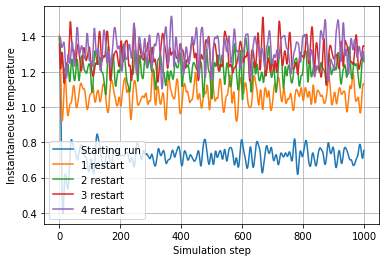

In [9]:
import numpy as np
import matplotlib.pyplot as plt

temp1=open('Temp_01.dat','r').read().split('\n')
temp2=open('Temp_02.dat','r').read().split('\n')
temp3=open('Temp_03.dat','r').read().split('\n')
temp4=open('Temp_04.dat','r').read().split('\n')
temp5=open('Temp_05.dat','r').read().split('\n')

x=[i for i in range(len(temp1)-1)]
y1=[]
y2=[]
y3=[]
y4=[]
y5=[]

for i in range(len(temp1)-1):
    y1.append(float(temp1[i]))
    y2.append(float(temp2[i]))
    y3.append(float(temp3[i]))
    y4.append(float(temp4[i]))
    y5.append(float(temp5[i]))
    
plt.plot(x,y1,label='Starting run')
plt.plot(x,y2,label='1 restart')
plt.plot(x,y3,label= '2 restart')
plt.plot(x,y4,label='3 restart')
plt.plot(x,y5,label='4 restart')

plt.xlabel('Simulation step')
plt.ylabel('Instantaneous temperature')
plt.grid(True)
plt.legend()
plt.show()

plt.close()


### EXERCISE 04.2

Until now, simulation calculated only the instantaneous values of $E_{pot}$,$E_{k}$,$E_{tot}$ and $T$, without estimation of the error. Thus, we introduce in this step the blocking method in order to calculate also the error on the mean values we obtain.

In the following a block calculation of the different values is shown. It is important to notice that, in this case, the system han $\textit{not}$ been equilibrated. The only purpose is to show the blocking method in action.

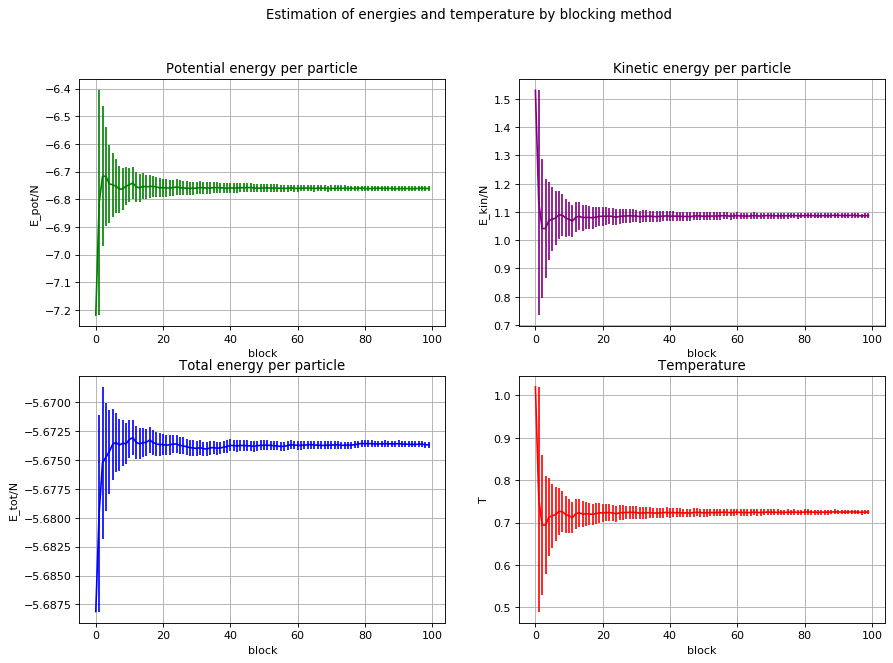

In [19]:
fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(2, 2,figsize=(13,9),dpi=80)

# Potential energy

data1=open('Generic_block/ave_epot.dat','r').read().split('\n')
x=[i for i in range(len(data1)-1)]

data1=[x.split(',') for x in data1]


y1= np.zeros(len(data1)-1)
y1_err= np.zeros(len(data1)-1)

for i in range(len(data1)-1):
    y1[i]=data1[i][0]
    y1_err[i]=data1[i][1]

# Kinetic energy

data2=open('Generic_block/ave_ekin.dat','r').read().split('\n')

data2=[x.split(',') for x in data2]


y2= np.zeros(len(data2)-1)
y2_err= np.zeros(len(data2)-1)

for i in range(len(data2)-1):
    y2[i]=data2[i][0]
    y2_err[i]=data2[i][1]

# Total energy

data3=open('Generic_block/ave_etot.dat','r').read().split('\n')

data3=[x.split(',') for x in data3]


y3= np.zeros(len(data3)-1)
y3_err= np.zeros(len(data3)-1)

for i in range(len(data3)-1):
    y3[i]=data3[i][0]
    y3_err[i]=data3[i][1]
    
# Temperature

data4=open('Generic_block/ave_temp.dat','r').read().split('\n')

data4=[x.split(',') for x in data4]


y4= np.zeros(len(data4)-1)
y4_err= np.zeros(len(data4)-1)

for i in range(len(data4)-1):
    y4[i]=data4[i][0]
    y4_err[i]=data4[i][1]

## Now we create the plot

ax1.errorbar(x,y1,yerr=y1_err,color='green')
ax1.set_title('Potential energy per particle')
ax1.set(xlabel='block', ylabel='E_pot/N')
ax2.errorbar(x,y2,yerr=y2_err,color='purple')
ax2.set_title('Kinetic energy per particle')
ax2.set(xlabel='block', ylabel='E_kin/N')
ax3.errorbar(x,y3,yerr=y3_err, color='blue')
ax3.set_title('Total energy per particle')
ax3.set(xlabel='block', ylabel='E_tot/N')
ax4.errorbar(x,y4,yerr=y4_err, color='red')
ax4.set_title('Temperature')
ax4.set(xlabel='block', ylabel='T')

fig.suptitle("Estimation of energies and temperature by blocking method")
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
ax4.grid(True)
plt.show()
plt.close()

### EXERCISE 04.3

Finally we can see the complete simulation procedure. In this case, the element simulated is the noble gas Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

Here is important to notice that the system has been equilibrated before measuring the data showed below.

All the values are show in SI units.

In [20]:
## Argon in solid phase

In [ ]:
## Argon in liquid phase

In [ ]:
## Argon in gas phase